In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from dataloader import get_Dataframe, applyCut, applyCutsJets
from unfold import weighted_binary_crossentropy, multifold

import os
os.environ['CUDA_VISIBLE_DEVICES']="1"

import tensorflow as tf
import tensorflow.keras.backend as K
tf.random.set_seed(1234)
np.random.seed(1234)

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '/data1/bpnachman/hera/'

In [3]:
mc_names = ['Rapgap','Rapgap','Rapgap','Rapgap','Rapgap','Rapgap','Django']
mc_tags = ['nominal','sys_0','sys_1','sys_5','sys_7','sys_11','nominal']

data_tag  = 'nominal'
period = 'ep0607'

In [4]:
reload = False #need to set this to true once, then much faster the second time.
rerun = True

In [5]:
if (reload):
    data = get_Dataframe(path, name='Data', tag=data_tag, verbose=False)
    data = applyCutsJets(data,verbose=False)
    data.to_pickle("datafiles/data.pkl")
else:
    data = pd.read_pickle("datafiles/data.pkl")

In [6]:
weights = {}
models = {}
history = {}

on sample: Rapgap nominal
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
on sample: Rapgap sys_0
ITERATION: 1
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
on sample: Rapgap sys_1
ITERATION: 1
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
on sample: Rapgap sys_5
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
on sample: Rapgap sys_7
ITERATION: 1
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
on sample: Rapgap sys_11
ITERATION: 1
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
on sample: Django nominal
ITERATION: 1
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...


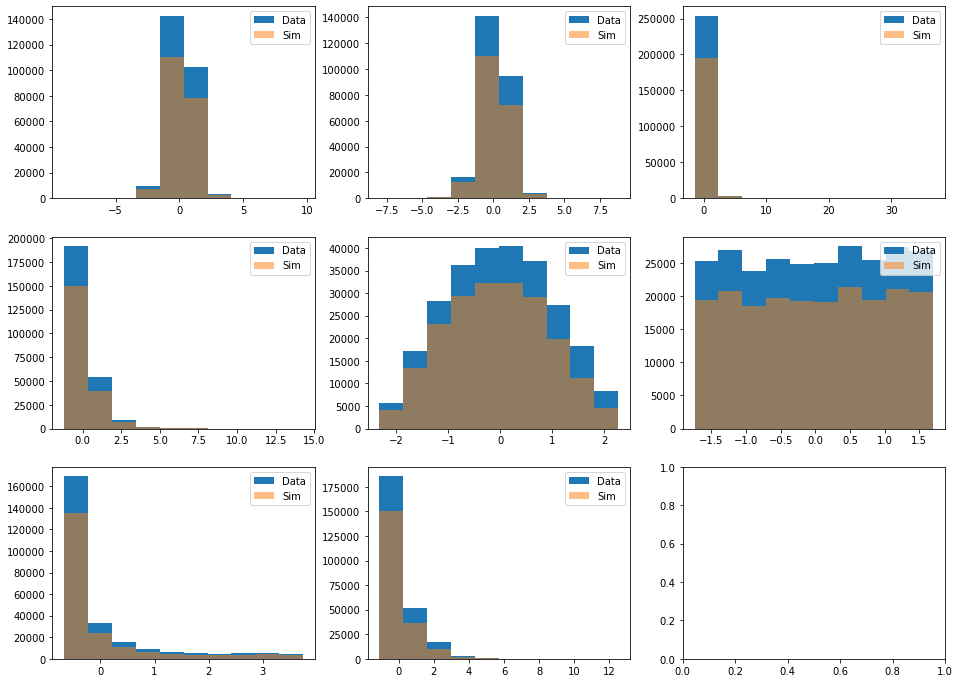

In [9]:
if (rerun):
    for mc_i in range(7):

        #Load files
        mc_name = mc_names[mc_i]
        mc_tag = mc_tags[mc_i]

        print("on sample:",mc_name,mc_tag)

        if (reload):
            mc = get_Dataframe(path, name=mc_name, tag=mc_tag)
            mc   = applyCutsJets(mc, isMC=True,verbose=False)
            mc.to_pickle("datafiles/"+mc_name+"_"+mc_tag+".pkl")
        else:
            mc = pd.read_pickle("datafiles/"+mc_name+"_"+mc_tag+".pkl")

        #Preprocessing
        theta_unknown_S = data[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
        theta0_S = mc[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
        theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
        weights_MC_sim = mc['wgt']
        pass_reco = np.array(mc['pass_reco'])
        pass_truth = np.array(mc['pass_truth'])

        #Standardize
        scaler_data = StandardScaler()
        scaler_data.fit(theta_unknown_S)

        scaler_mc_truth = StandardScaler()
        scaler_mc_truth.fit(theta0_G[pass_truth==1])

        theta_unknown_S_scaled = scaler_data.transform(theta_unknown_S)
        theta0_S_scaled = scaler_data.transform(theta0_S)
        theta0_G_scaled = scaler_mc_truth.transform(theta0_G)

        weights_MC_sim_scaled = weights_MC_sim/np.average(weights_MC_sim)

        #Acceptance effects
        theta0_S_scaled[:,0][pass_reco==0] = -10
        theta0_G_scaled[:,0][pass_truth==0] = -10

        weights_MC_sim_scaled *= len(theta_unknown_S_scaled)/len(theta0_S_scaled)

        if (mc_i==0):
            fig , ax = plt.subplots(3,3,figsize=(16,12))
            ax = ax.flatten()
            for i in range(len(theta_unknown_S[0])):
                n,b,_=ax[i].hist(theta_unknown_S_scaled[:,i],label="Data")
                ax[i].hist(theta0_S_scaled[:,i][theta0_S_scaled[:,0]!=-10],bins=b,alpha=0.5,weights=weights_MC_sim_scaled[theta0_S_scaled[:,0]!=-10],label="Sim")
                ax[i].legend()

        iterations = 5
        num_observables = 8

        for j in range(5):
            K.clear_session()
            weights[mc_i,j], models[mc_i,j], history[mc_i,j] = multifold(num_observables=num_observables,
                                   iterations=iterations,
                                   theta0_G=theta0_G_scaled,
                                   theta0_S=theta0_S_scaled,
                                   theta_unknown_S= theta_unknown_S_scaled,verbose=0,weights_MC_sim=weights_MC_sim_scaled)

In [14]:
bins = {}
dologx = [True,False,False,True]
dology = [True,False,True,True]

#jet pt
bins[0] = np.logspace(np.log10(10),np.log10(100),7)

#jet eta
bins[1] = np.linspace(-1,2.5,6)

#dphi
bins[2] = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins[2] = bins[2][1:]
bins[2][0] = 0.0

#qt
bins[3] = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins[3] = bins[3][1:]
bins[3][0] = 0.0

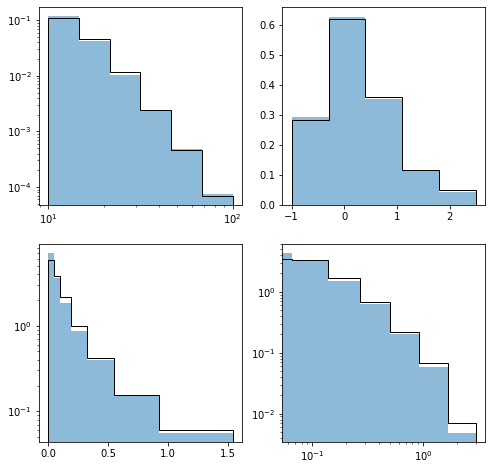

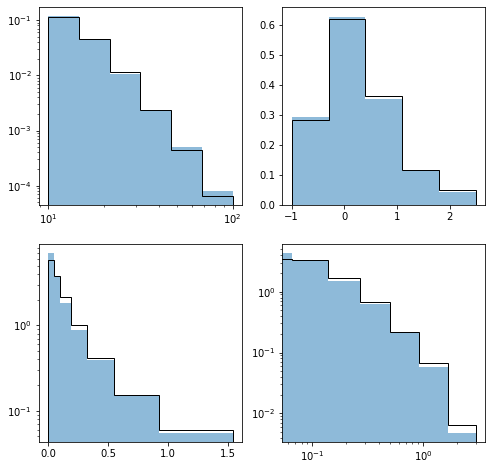

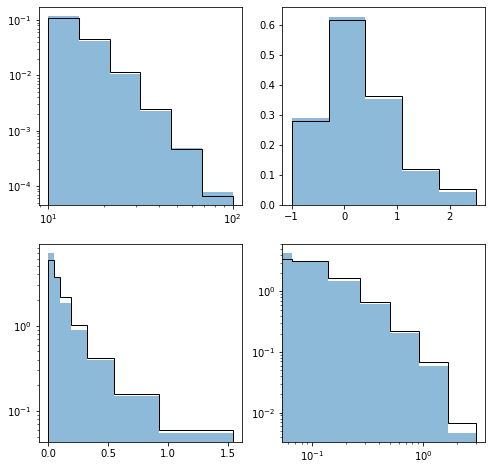

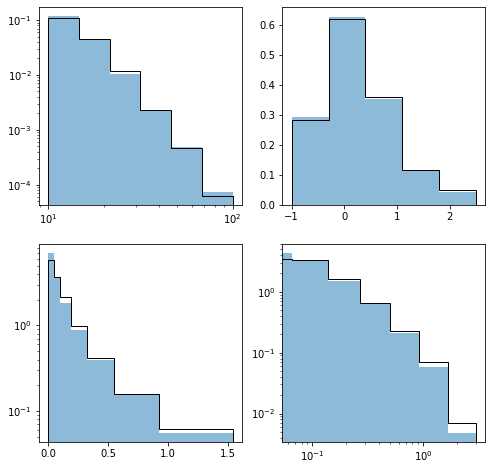

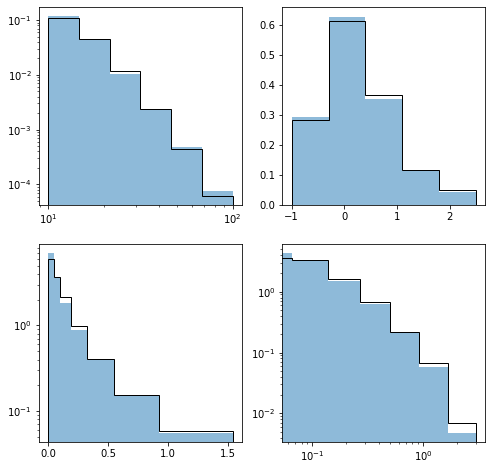

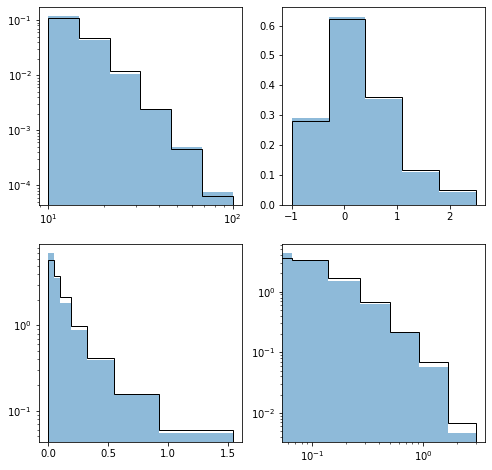

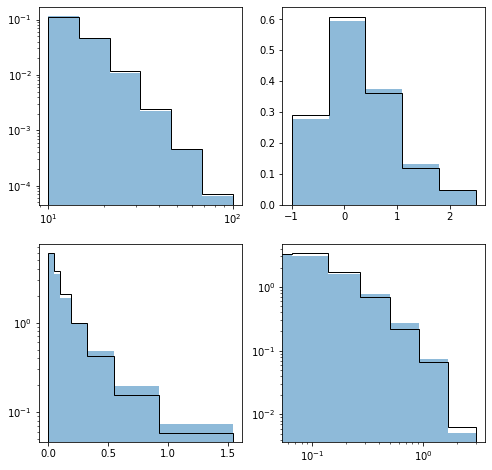

In [10]:
#Now, let's average the weights.
unfolded_vals = {}
for mc_i in range(7):
    
    #Load files
    mc_name = mc_names[mc_i]
    mc_tag = mc_tags[mc_i]

    mc = pd.read_pickle("datafiles/"+mc_name+"_"+mc_tag+".pkl")
    pass_reco = np.array(mc['pass_reco'])
    pass_truth = np.array(mc['pass_truth'])
    pass_fiducial = np.array(mc['pass_fiducial'])
    
    if (rerun):
        ww = np.mean([weights[mc_i,0][-1,1,:][pass_truth==1],
              weights[mc_i,1][-1,1,:][pass_truth==1],
              weights[mc_i,2][-1,1,:][pass_truth==1],
              weights[mc_i,3][-1,1,:][pass_truth==1],
              weights[mc_i,4][-1,1,:][pass_truth==1]],axis=0)
        np.save(mc_name+"_"+mc_tag,ww)
    else:
        ww = np.load(mc_name+"_"+mc_tag+".npy")
    
    theta0_G = mc[['genjet_pt','genjet_eta','genjet_dphi','genjet_qtnorm']].to_numpy()
    weights_MC_sim = mc['wgt']
        
    fig , ax = plt.subplots(2,2,figsize=(8,8))
    ax = ax.flatten()
    for i in range(4):
        ax[i].hist(theta0_G[pass_fiducial==1][:,i],bins=bins[i],weights=weights_MC_sim[pass_fiducial==1],density=True,alpha=0.5)
        unfolded_vals[mc_i,i],_,_ = ax[i].hist(theta0_G[pass_fiducial==1][:,i],bins=bins[i],weights=ww[pass_fiducial==1],density=True,histtype="step",color="black")
        if (dologx[i]):
            ax[i].set_xscale('log')
        if (dology[i]):
            ax[i].set_yscale('log')

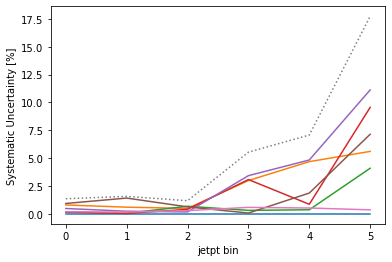

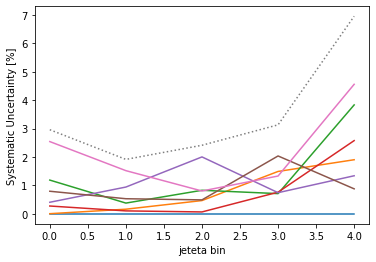

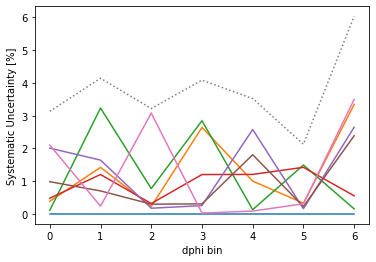

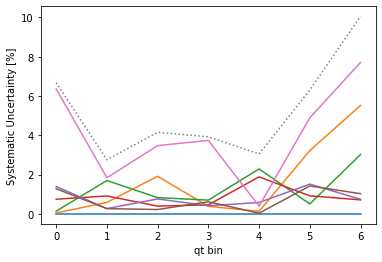

In [23]:
mylabels = ['jetpt','jeteta','dphi','qt']
for j in range(4):
    plt.figure()
    mytot = np.zeros(len(unfolded_vals[(0,j)]))
    for mc_i in range(7):
        mytot += (abs((unfolded_vals[(0,j)]-unfolded_vals[(mc_i,j)])/unfolded_vals[(0,j)]))**2
        plt.plot(100*abs((unfolded_vals[(0,j)]-unfolded_vals[(mc_i,j)])/unfolded_vals[(0,j)]))
    plt.plot(100*mytot**0.5,ls=":")
    plt.ylabel("Systematic Uncertainty [%]")
    plt.xlabel(mylabels[j]+" bin")
    
    with open('outputfiles/ResultwithSystematicUncertainties_%s_ensemble.npy'%(mylabels[j]), 'wb') as f:
        np.save(f,0.5*(bins[0][0:-1]+bins[0][1:]))
        np.save(f,unfolded_vals[(0,j)])
        np.save(f,0.5*abs(bins[0][0:-1]-bins[0][1:]))
        np.save(f, mytot)

In [126]:
#Check the quality of the fits
if (1==2):
    for i in range(iterations):
        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].set_title('model loss')
        ax[0].set_xlabel('epoch number')
        ax[0].plot(history[0,0]['step1'][i].history['loss'][1:],'o',label='Step 1 train')
        ax[0].plot(history[0,0]['step1'][i].history['val_loss'][1:],'o',label='Step 1 test')

        ax[1].set_title('model accuracy')
        ax[1].plot(history[0,0]['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
        ax[1].plot(history[0,0]['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
        ax[1].legend()
        ax[1].set_xlabel('epoch number')
        ax[1].set_yscale('log')
        ax[0].legend()
        
    for j in range(iterations):
    fig , ax = plt.subplots(3,3,figsize=(16,12))
    ax = ax.flatten()
    for i in range(len(theta_unknown_S[0])):
        n,b,_=ax[i].hist(theta_unknown_S[:,i],density=True,label="Data")
        ax[i].hist(theta0_S[:,i][pass_reco==1],bins=b,alpha=0.5,density=True,label="Sim")
        ax[i].hist(theta0_S[:,i][pass_reco==1],bins=b,histtype="step",density=True,color="black",ls=":",lw=3,weights=weights[0,0][j,0,:][pass_reco==1],label="Weighted sim")
        ax[i].legend()